In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train_df = pd.read_csv('/kaggle/input/creating-additional-features-for-pan-clef/train.csv')
test_df = pd.read_csv('/kaggle/input/creating-additional-features-for-pan-clef/test.csv')

coling_test = pd.read_csv('/kaggle/input/creating-with-new-features-coling/coling_test3000.csv')

In [13]:
FEATURES = ['character_count',
       'word_count', 'sentence_count', 'paragraph_count', 'stopword_count',
       'unique_word_count', 'sentiment_polarity',
       'sentiment_subjectivity', 'discourse_marker_count', 'vocab_size',
       'sentence_complexity', 'punctuation_count',
       'sentence_length_difference', 'word_entropy',
       'flesch_reading_ease', 'gzip_ratio', 'negation_freq',
       'question_stmt_ratio', 'clause_sentence_ratio', 'modal_freq',
       'pronoun_ratio', 'pos_diversity', 'hapax_ratio','sentence_length_variation','type_token_ratio','repetition_rate', 'personal_voice_score',
       'emotion_variation', 'specificity_score', 'figurative_language_score',
       'paragraph_coherence_consistency', 'predictability_score',
       'hedge_uncertainty_score', 'transition_variety_score']

TARGET = 'label'

In [14]:
## pan data
X_train = train_df[FEATURES]
y_train = train_df[TARGET]

X_test = test_df[FEATURES]
y_test = test_df[TARGET]


#coling data
coling_test_data = coling_test[FEATURES]
coling_test_label = coling_test[TARGET]

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif, f_classif
from scipy.stats import pearsonr

# ---------------------------------------------------------
# 1. Compute label association (correlation, MI, F-score)
# ---------------------------------------------------------

def compute_feature_association(X, y):
    associations = []

    # Mutual Information
    mi_scores = mutual_info_classif(X, y, discrete_features=False)

    # ANOVA F-score
    f_scores, _ = f_classif(X, y)

    for idx, feat in enumerate(X.columns):
        # Pearson correlation (fallback to 0 if NaN)
        try:
            corr = pearsonr(X[feat], y)[0]
        except:
            corr = 0.0

        associations.append({
            "Feature": feat,
            "Correlation": round(corr, 4),
            "Mutual_Information": round(mi_scores[idx], 4),
            "F_Score": round(f_scores[idx], 4),
            "Combined_Rank_Score": abs(corr) + mi_scores[idx] + f_scores[idx]
        })

    assoc_df = pd.DataFrame(associations)
    assoc_df = assoc_df.sort_values("Combined_Rank_Score", ascending=False)
    return assoc_df


# ---------------------------------------------------------
# 2. Distribution plot for top features
# ---------------------------------------------------------

def plot_feature_distribution(df, feature, label_col='label'):
    plt.figure(figsize=(6, 4))
    sns.histplot(
        data=df, 
        x=feature, 
        hue=label_col, 
        kde=True, 
        bins=30,
        palette="coolwarm",
        alpha=0.6
    )
    plt.title(f"Distribution of {feature} by Class")
    plt.tight_layout()
    plt.show()


# ---------------------------------------------------------
# 3. Cohen's d effect size
# ---------------------------------------------------------

def cohens_d(group1, group2):
    mean1, mean2 = group1.mean(), group2.mean()
    var1, var2 = group1.var(), group2.var()
    
    pooled_std = np.sqrt(((len(group1) - 1)*var1 + (len(group2) - 1)*var2) / 
                         (len(group1) + len(group2) - 2))
    
    if pooled_std == 0:
        return 0.0
    return (mean2 - mean1) / pooled_std


# ---------------------------------------------------------
# 4. Compute effect sizes for selected features
# ---------------------------------------------------------

def compute_feature_effect_sizes(df, features, label_col='label'):
    results = []
    human = df[df[label_col] == 0]
    ai = df[df[label_col] == 1]

    for feat in features:
        d = cohens_d(human[feat], ai[feat])
        results.append({
            "Feature": feat,
            "Human_Mean": round(human[feat].mean(), 4),
            "AI_Mean": round(ai[feat].mean(), 4),
            "Effect_Size_d": round(d, 4)
        })

    return pd.DataFrame(results).sort_values("Effect_Size_d", ascending=False)


# ---------------------------------------------------------
# 5. Dataset Drift Analysis (Train vs COLING)
# ---------------------------------------------------------

def dataset_drift_analysis(train_df, test_df, features):
    drift = []
    for feat in features:
        drift.append({
            "Feature": feat,
            "Train_Mean": round(train_df[feat].mean(), 4),
            "COLING_Mean": round(test_df[feat].mean(), 4),
            "Absolute_Drift": round(abs(train_df[feat].mean() - test_df[feat].mean()), 4)
        })
    return pd.DataFrame(drift).sort_values("Absolute_Drift", ascending=False)


# ---------------------------------------------------------
# 6. Correlation Heatmap for top features
# ---------------------------------------------------------

def plot_correlation_heatmap(df, features):
    plt.figure(figsize=(10, 7))
    sns.heatmap(df[features].corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap (Top Features)")
    plt.tight_layout()
    plt.show()


# ---------------------------------------------------------
# 7. Master Function to Run Full Feature EDA
# ---------------------------------------------------------

def run_feature_eda(X_train, y_train, coling_data, top_k=15):
    print("\n🔍 STEP 1 — Computing Feature–Label Association...")
    assoc = compute_feature_association(X_train, y_train)
    print(assoc.head(top_k))

    top_features = assoc.head(top_k)["Feature"].tolist()

    # Combine DF for label-based analysis
    df_train = X_train.copy()
    df_train["label"] = y_train.values

    print("\n📊 STEP 2 — Plotting Distributions for Top Features...")
    for feat in top_features:
        plot_feature_distribution(df_train, feat)

    print("\n📈 STEP 3 — Computing Effect Sizes...")
    effect_df = compute_feature_effect_sizes(df_train, top_features)
    print(effect_df)

    print("\n⚠️ STEP 4 — Dataset Drift (Train vs COLING)...")
    drift_df = dataset_drift_analysis(X_train, coling_data, top_features)
    print(drift_df)

    print("\n🔗 STEP 5 — Correlation Heatmap for Top Features...")
    plot_correlation_heatmap(X_train, top_features)

    return {
        "association": assoc,
        "top_features": top_features,
        "effect_sizes": effect_df,
        "dataset_drift": drift_df
    }



🔍 STEP 1 — Computing Feature–Label Association...
                       Feature  Correlation  Mutual_Information     F_Score  \
21               pos_diversity      -0.6803              0.3329  20419.9572   
10         sentence_complexity      -0.5188              0.1871   8732.2548   
16               negation_freq      -0.5023              0.2001   7997.6319   
28           specificity_score       0.4941              0.1702   7658.1887   
14         flesch_reading_ease      -0.4648              0.1359   6532.7384   
20               pronoun_ratio      -0.4159              0.1038   4957.9236   
12  sentence_length_difference      -0.4078              0.2079   4729.5979   
4               stopword_count      -0.3998              0.1426   4510.6332   
19                  modal_freq      -0.3743              0.1518   3861.0142   
23   sentence_length_variation      -0.3612              0.2368   3557.2560   
11           punctuation_count      -0.3273              0.0748   2844.0337   
2

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


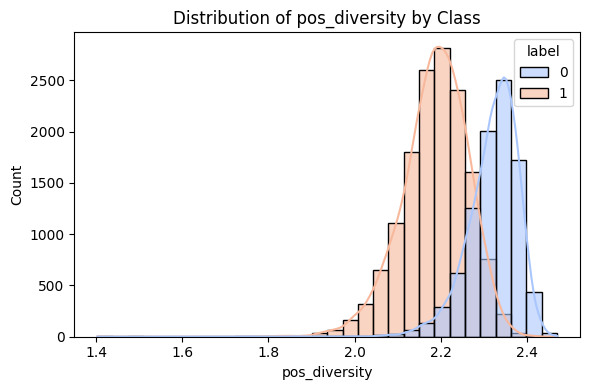

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


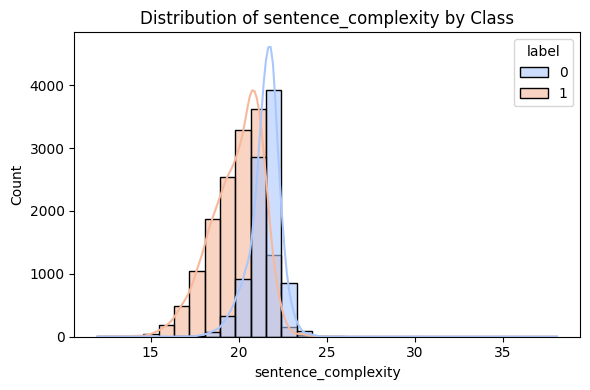

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


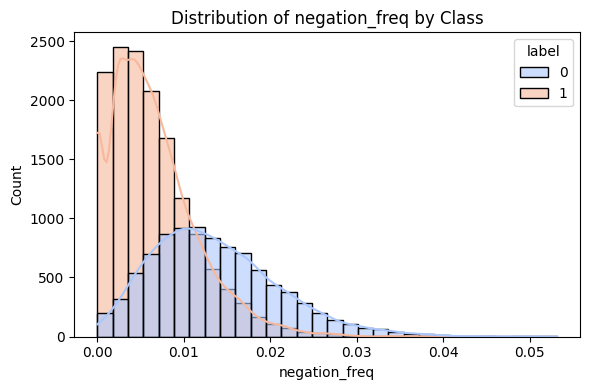

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


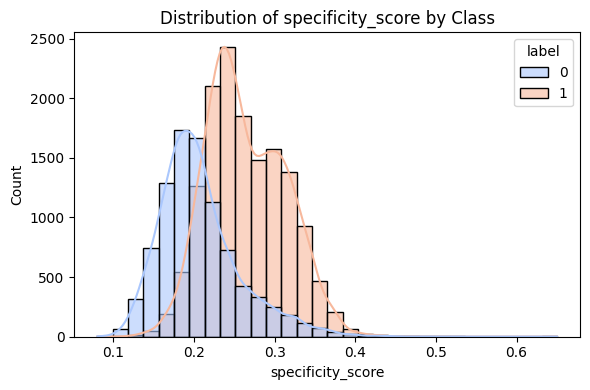

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


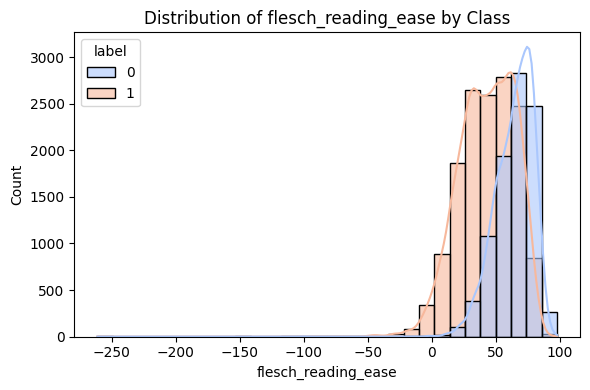

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


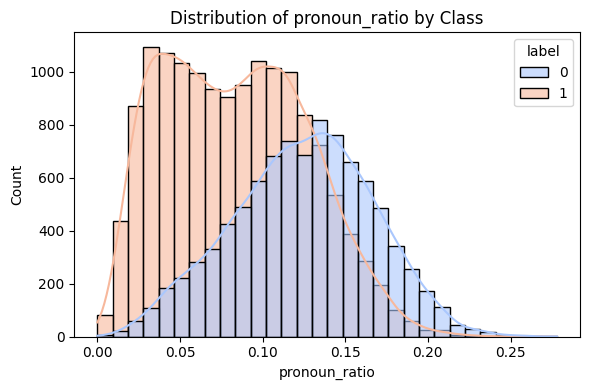

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

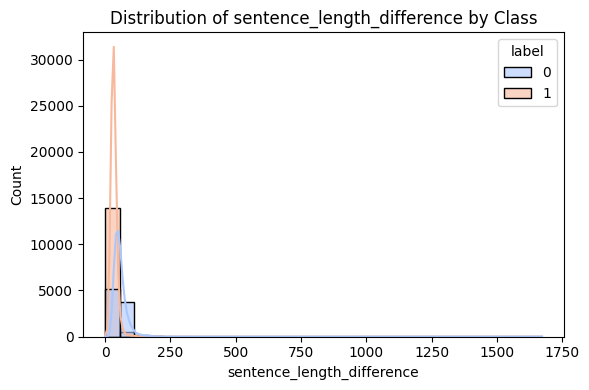

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

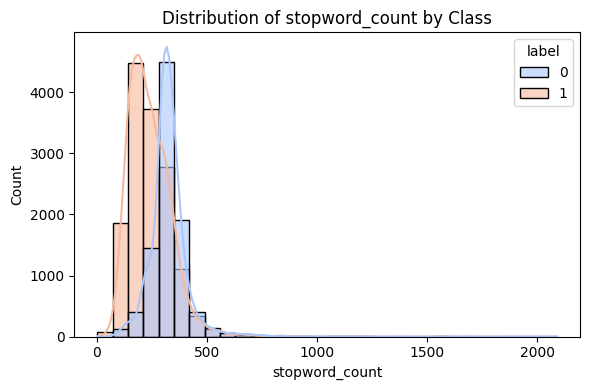

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


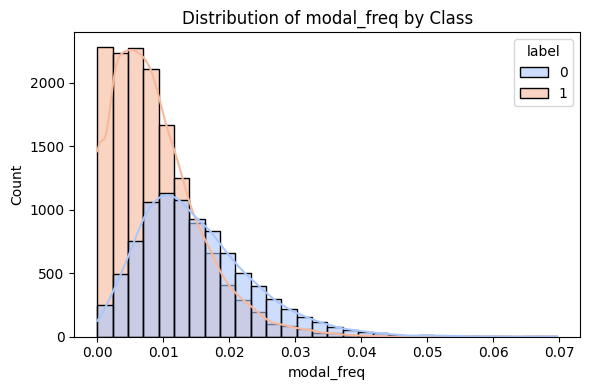

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


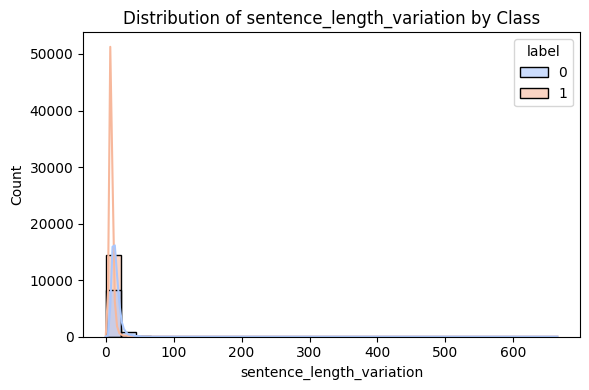

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

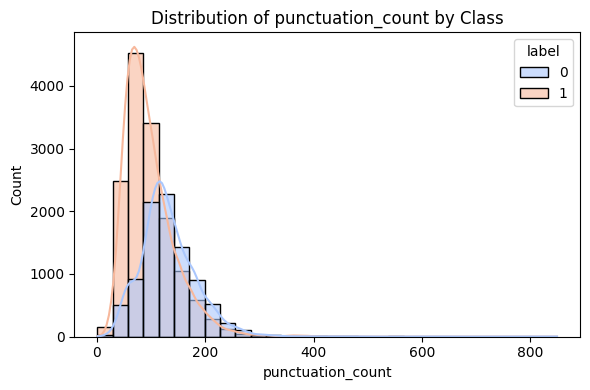

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


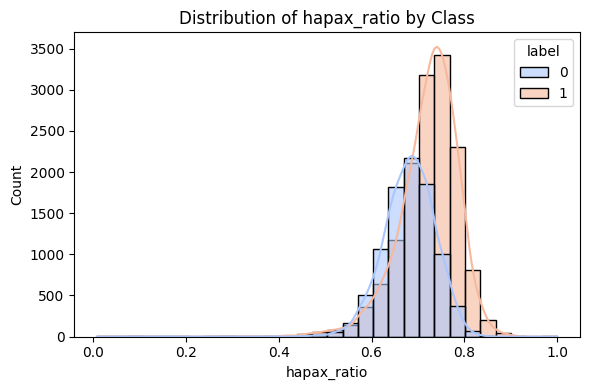

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


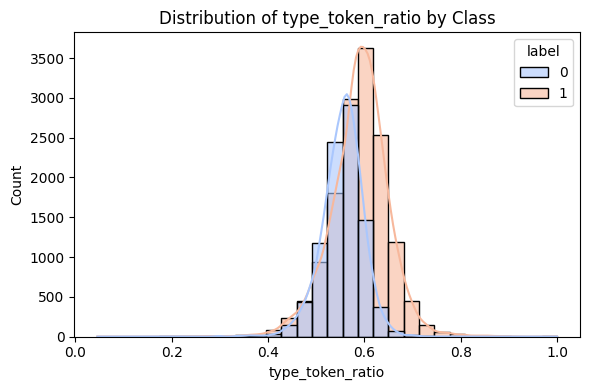

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


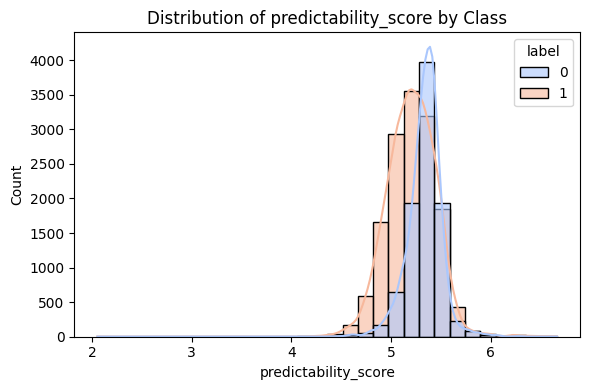

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

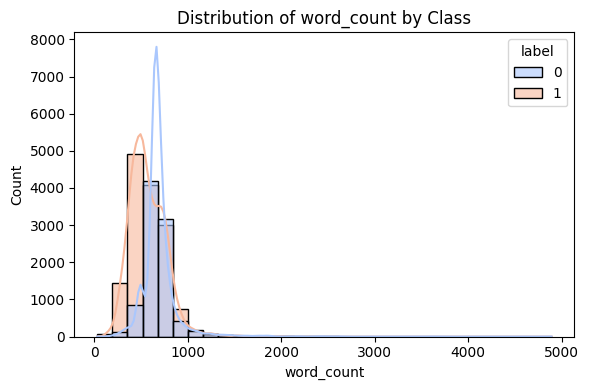


📈 STEP 3 — Computing Effect Sizes...
                       Feature  Human_Mean   AI_Mean  Effect_Size_d
3            specificity_score      0.2067    0.2644         1.1687
11                 hapax_ratio      0.6811    0.7225         0.6605
12            type_token_ratio      0.5547    0.5899         0.6421
14                  word_count    695.4563  574.9729        -0.5953
13        predictability_score      5.3370    5.2036        -0.6047
10           punctuation_count    131.9817   96.8554        -0.7122
9    sentence_length_variation     14.6951    8.5799        -0.7965
8                   modal_freq      0.0149    0.0087        -0.8298
7               stopword_count    326.2326  239.5859        -0.8969
6   sentence_length_difference     57.1651   35.0929        -0.9184
5                pronoun_ratio      0.1242    0.0839        -0.9403
4          flesch_reading_ease     64.2605   43.2549        -1.0794
2                negation_freq      0.0136    0.0064        -1.1943
1         

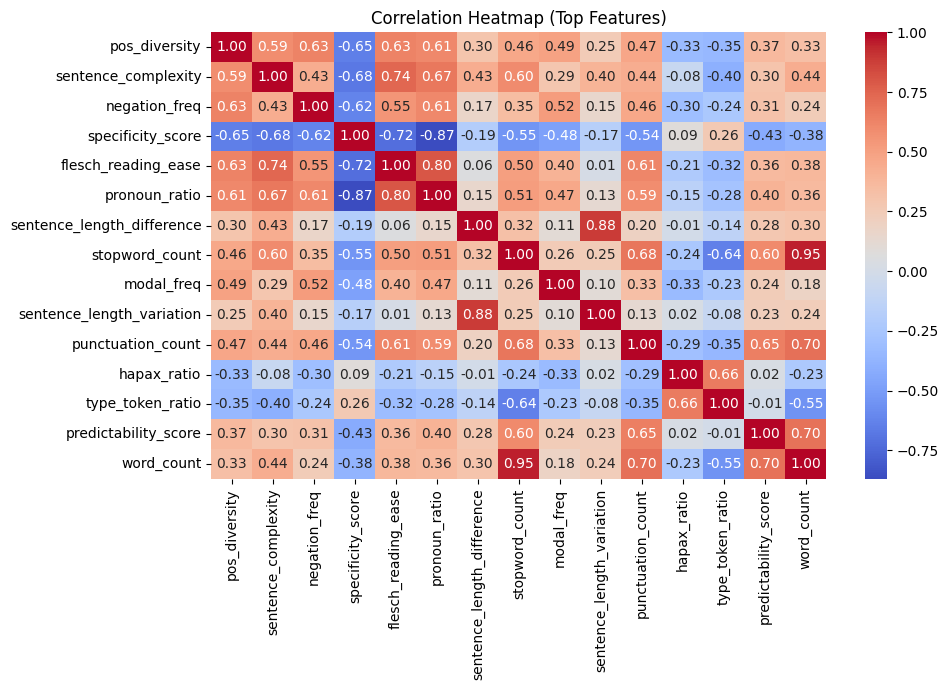

In [20]:
results = run_feature_eda(
    X_train=X_train,
    y_train=y_train,
    coling_data=coling_test_data,
    top_k=15
)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


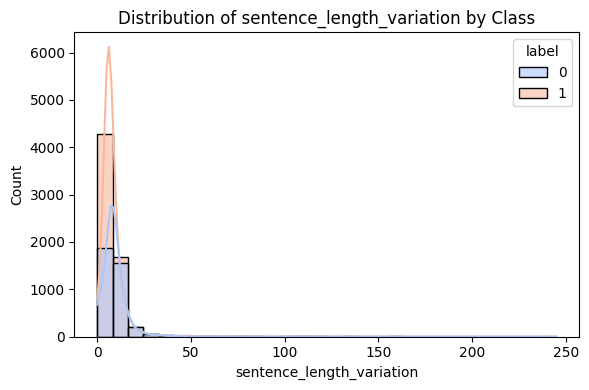

In [37]:
plot_feature_distribution(coling_test,'sentence_length_variation')

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


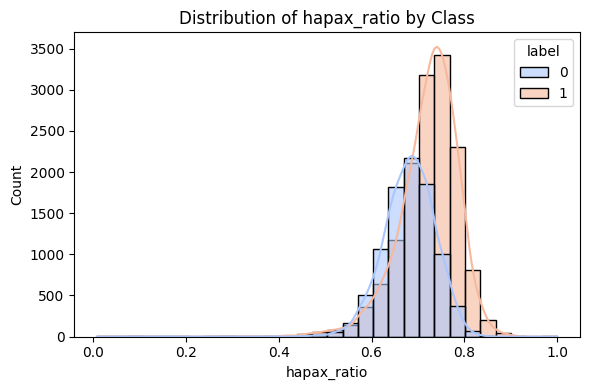

In [36]:
plot_feature_distribution(train_df,'hapax_ratio')